cuda


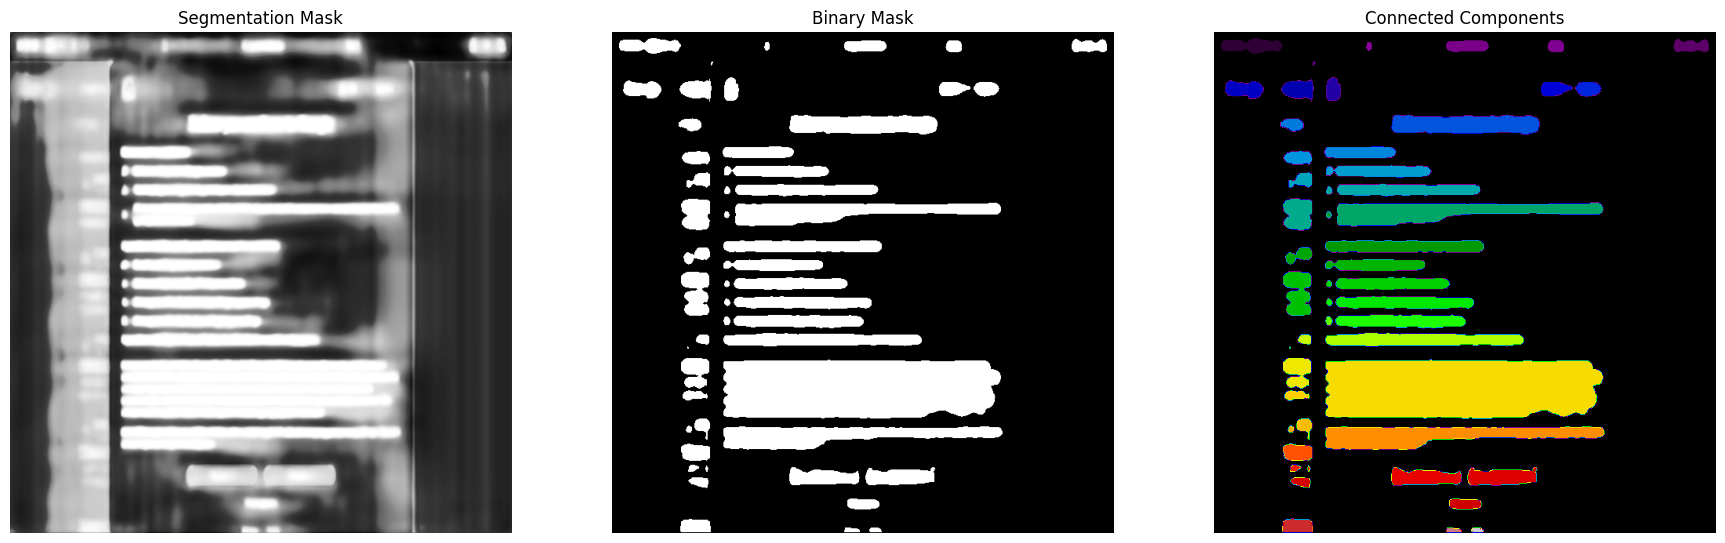

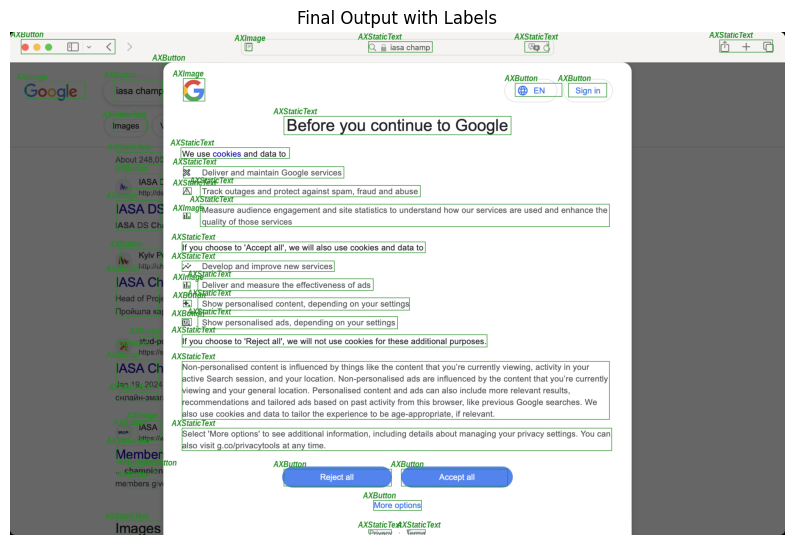

In [9]:
import torch
import torch.nn as nn
from src.UNET import UNet as SegmentationModel
from src.UIElementClassifier import UIElementClassifier

def load_model(model_class, checkpoint_path, num_classes, device):
    if model_class == SegmentationModel:
        model = model_class(n_channels=3, n_classes=1, bilinear=True)
    else:
        model = model_class(num_classes=num_classes)

    model = model.to(device)

    # If multiple GPUs are available, wrap the model with DataParallel
    if model_class == SegmentationModel and torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()
    return model


import torch
from torchvision import transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from scipy.ndimage import label
import numpy as np
from tqdm import tqdm
from PIL import ImageFont

def process_image(image_path, segmentation_model, classification_model, device):
    original_image = Image.open(image_path).convert('RGB')
    original_width, original_height = original_image.size

    process_size = 640
    scale_width = original_width / process_size
    scale_height = original_height / process_size

    # Transformation for the model input
    transform = transforms.Compose([
        transforms.Resize((process_size, process_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = transform(original_image).unsqueeze(0).to(device)

    # Segmentation
    with torch.no_grad():
        masks = segmentation_model(input_tensor)
        mask_probabilities = torch.sigmoid(masks)
    plt.figure(figsize=(22, 22))
    plt.subplot(2, 3, 1)
    plt.imshow(transforms.ToPILImage()(mask_probabilities.cpu().squeeze(0).squeeze(0)), cmap='gray')
    plt.title('Segmentation Mask')
    plt.axis('off')
    # Threshold to create a binary mask
    binary_masks = (mask_probabilities > 0.8).float()
    binary_masks_np = binary_masks.cpu().squeeze(0).squeeze(0).numpy()
 
 # Visualize the binary mask
    plt.subplot(2, 3, 2)
    plt.imshow(binary_masks_np, cmap='gray')
    plt.title('Binary Mask')
    plt.axis('off')
    # Connected component labeling
    structure = np.ones((3, 3), dtype=int)
    labeled, ncomponents = label(binary_masks_np, structure)
    plt.subplot(2, 3, 3)
    plt.imshow(labeled, cmap='nipy_spectral')
    plt.title('Connected Components')
    plt.axis('off')
    # Visualization setup
    draw = ImageDraw.Draw(original_image)
    transform_resize = transforms.Resize((64, 64))
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    # Processing each component detected
    for comp in range(1, ncomponents + 1):
        where = np.where(labeled == comp)
        if where[0].size > 0 and where[1].size > 0:
            # Calculate bounding box coordinates and scale them
            y1, y2, x1, x2 = where[0].min(), where[0].max(), where[1].min(), where[1].max()
            scaled_x1, scaled_x2 = int(x1 * scale_width), int(x2 * scale_width)
            scaled_y1, scaled_y2 = int(y1 * scale_height), int(y2 * scale_height)

            # Crop and resize for classification
            obj_img = original_image.crop((scaled_x1, scaled_y1, scaled_x2, scaled_y2))
            obj_img = transform_resize(obj_img)
            obj_tensor = transform(obj_img).unsqueeze(0).to(device)

            # Classify the object
            with torch.no_grad():
                outputs = classification_model(obj_tensor)
                _, predicted = torch.max(outputs, 1)
                class_label = {0: 'AXStaticText', 1: 'AXButton', 2: 'AXImage'}[predicted.item()]

            # Draw bounding box and label on the original image
            draw.rectangle([scaled_x1, scaled_y1, scaled_x2, scaled_y2], outline='forestgreen', width=2)

            font_path = '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf'  # Common path for DejaVu Sans in many Linux systems
            font_size = 30
            font = ImageFont.truetype(font_path, font_size)


            draw.text((scaled_x1-35, scaled_y1-35), class_label, fill='forestgreen', font=font)

    # Display the final annotated image
    plt.figure(figsize=(10, 10))
    plt.imshow(original_image)
    plt.title('Final Output with Labels')
    plt.axis('off')
    plt.show()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Load models
classification_model = load_model(UIElementClassifier, 'models_checkpoints/best_model_classification.pth', num_classes=3, device=device)
segmentation_model = load_model(SegmentationModel, 'models_checkpoints/checkpoint_UNET.pt', num_classes=1, device=device)

# Process an example image
process_image('data/MAC/test/Safari/1707176428/Safari-1707176429.48.png', segmentation_model, classification_model, device)